#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import lightgbm as lgb
import lightgbm as lgm
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
#Делаем ресемпл 1 час
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


После ознакомления с датасетом я сделал округлил значения времени до 1 часа, менять тип столбца datetime не требуется. 

## Анализ

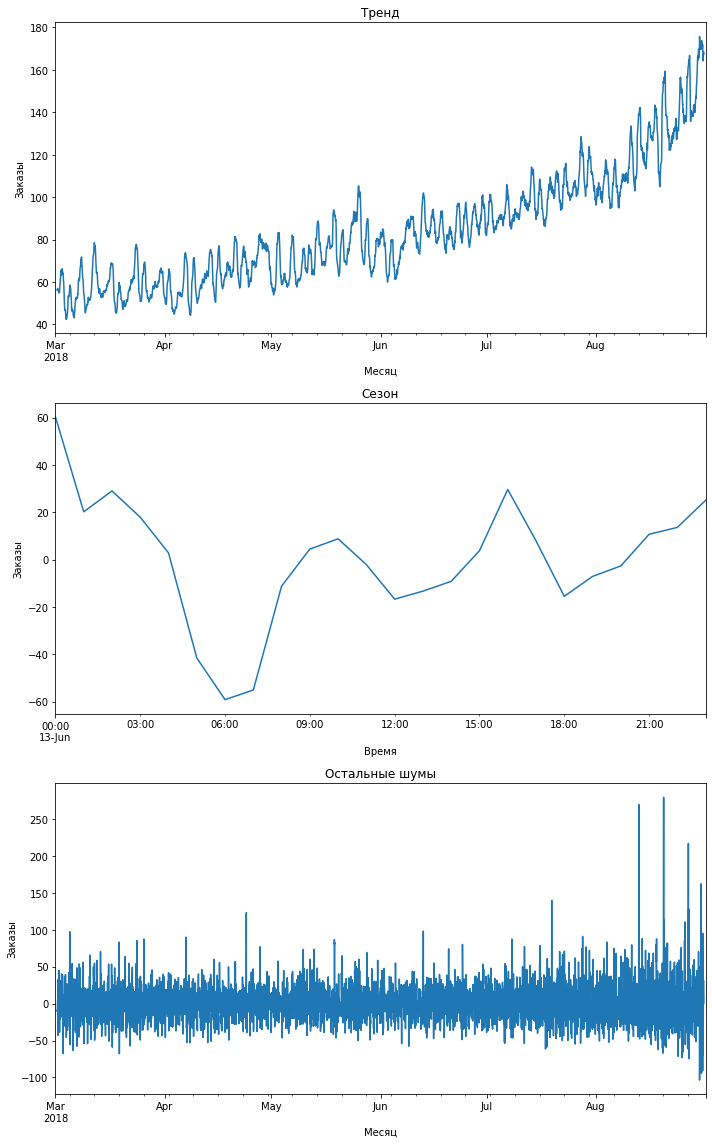

In [4]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Месяц")
plt.ylabel("Заказы")
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-13'].plot(ax=plt.gca())
plt.title('Сезон')
plt.xlabel("Время")
plt.ylabel("Заказы")
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Остальные шумы')
plt.xlabel("Месяц")
plt.ylabel("Заказы")
plt.tight_layout()

Text(0, 0.5, 'Заказы')

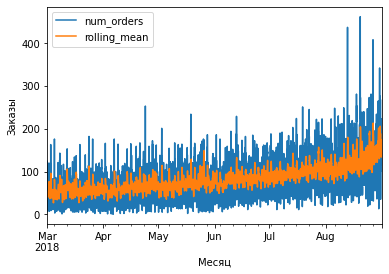

In [5]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()
plt.xlabel("Месяц")
plt.ylabel("Заказы")

После декомпозиции можно отметить из тренда, что количество заказов растет, из сезонности можно понять, что больше всего заказов ночью в 00:00 и меньше всего заказов в 06:00 утра.

## Обучение

In [6]:
#Создадим и применим функцию make_features
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 10)
data.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,2018,3,1,3,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,2018,3,1,3,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,2018,3,1,3,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,2018,3,1,3,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Удаляем пропуски и проверяем
data = data.dropna()
data.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,61.7,2018,3,2,4,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,65.9,2018,3,2,4,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,71.3,2018,3,2,4,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,74.5,2018,3,2,4,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,76.5,2018,3,2,4,64.0,75.0,120.0,90.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 05:00:00,11,71.2,2018,3,2,4,20.0,64.0,75.0,120.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0
2018-03-02 06:00:00,11,67.8,2018,3,2,4,11.0,20.0,64.0,75.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0
2018-03-02 07:00:00,7,62.8,2018,3,2,4,11.0,11.0,20.0,64.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0
2018-03-02 08:00:00,46,56.9,2018,3,2,4,7.0,11.0,11.0,20.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0


In [8]:
# Создаем признаки 
features = data.drop(['num_orders'], axis = 1)  
target = data['num_orders'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, shuffle=False)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, shuffle=False)

print('Размер тренировочной выборки:', features_train.shape) 
print('Размер тестовой выборки:', features_test.shape) 
print('Размер валидационной выборки:', features_valid.shape) 
print(data.shape)

Размер тренировочной выборки: (3513, 29)
Размер тестовой выборки: (439, 29)
Размер валидационной выборки: (440, 29)
(4392, 30)


Лучшие параметры max_depth=10, n_estimators=200

In [10]:
#Проверяем модель LGBMRegressor

light_gbm = lgb.LGBMRegressor(num_leaves= 16, learning_rate=0.01, max_depth=10, n_estimators=200)
light_gbm.fit(features_train, target_train)
pred4 = light_gbm.predict(features_valid)
rmse_light_gbm = mean_squared_error(target_valid, pred4)**0.5
rmse_light_gbm

59.26299870434133

In [11]:
#Проверяем модель CatBoostRegressor

model_cat = CatBoostRegressor(n_estimators = 1000, loss_function = 'MAE', eval_metric = 'RMSE')
model_cat.fit(features_train, target_train, verbose=100)
predicted_valid2 = model_cat.predict(features_valid)
rmse_cat = (mean_squared_error(target_valid, predicted_valid2))**0.5
rmse_cat

0:	learn: 35.3485376	total: 55.9ms	remaining: 55.8s
100:	learn: 22.9480632	total: 619ms	remaining: 5.51s
200:	learn: 21.0058770	total: 1.16s	remaining: 4.62s
300:	learn: 19.8907313	total: 1.7s	remaining: 3.95s
400:	learn: 18.9105647	total: 2.25s	remaining: 3.37s
500:	learn: 18.1947623	total: 2.81s	remaining: 2.8s
600:	learn: 17.6036402	total: 3.39s	remaining: 2.25s
700:	learn: 17.0271949	total: 3.97s	remaining: 1.69s
800:	learn: 16.5837216	total: 4.56s	remaining: 1.13s
900:	learn: 16.2280458	total: 5.13s	remaining: 563ms
999:	learn: 15.8799148	total: 5.67s	remaining: 0us


55.18503147297283

После тестирования модель CatBoost показала лучшие результаты, осталось провести финальное тестирование модели.

## Тестирование

In [12]:
# Финальное тестирование модели CatBoostRegressor
predicted_valid3 = model_cat.predict(features_test)
rmse_cat_test = mean_squared_error(target_test, predicted_valid3)**0.5
rmse_cat_test

33.9913650258038

***Вывод***:

После ознакомления с датасетом был сделан ресемпл до 1 часа, и я приступил к анализу. Была сделана декомпозиция из которой можно отметить, что количество заказов растет ближе к 12 ночи и уменьшается ближе к 6 утра и 6 вечера. Количество заказов растет ночью в связи с тем, что общественный транспорт перестает ходить. Далее я создал функцию make_features и разделил дата сет как сказанно в условии на 3 части тренировочную валидационную и тестовую(10% от общей). Далее я начал лучшие параметры для модели ими оказались  max_depth: 10, n_estimators: 200. После чего я обучил модели LGBMRegressor и CatBoost. Обе модели показали хороший результат, но модель CatBoost результат лучше. CatBoost лучшая модель.